In [12]:
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import ElasticNet
import logging
import sys
import json
import os
from datetime import datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sns.set_palette("Dark2")

In [3]:
config_file = '../../configs/cancer_type/lgbm_grid_search_cancertype.json'
configs = json.load(open(config_file, 'r'))

In [4]:
seed = configs['seed']
cv = StratifiedKFold(n_splits=configs['cv'], shuffle=True, random_state=seed)

data_sample = pd.read_csv('../../data/cancer_type/cancer_tissue_type_protein.tsv', sep='\t')

data_sample = data_sample.drop(['Cell_line'], axis=1)
data_sample = data_sample[~data_sample['Cancer_type'].str.contains('Other')]
type_count = data_sample.groupby([configs['target']]).size()
selected_types = type_count[type_count > configs['cut_off']].index.values
data_sample = data_sample[data_sample[configs['target']].isin(selected_types)].reset_index(drop=True)
proteins = np.array([x for x in data_sample.columns if '_HUMAN' in x])
X = data_sample[proteins]
y = data_sample[configs['target']]
imputer = None
if configs['imputer'] == 'mean':
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
elif configs['imputer'] == 'KNN':
    imputer = KNNImputer(missing_values=np.nan)
elif configs['imputer'] == 'zero':
    imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
elif configs['imputer'] == 'min':
    imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=configs['min_val'])

if imputer:
    X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed, shuffle=True,
                                                    test_size=0.2)

In [5]:
params = {'max_bin': 200, 'n_estimators': 300, 'num_leaves': 31, 'n_jobs': -1}
clf = LGBMClassifier(**params)

In [6]:
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_bin=200,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

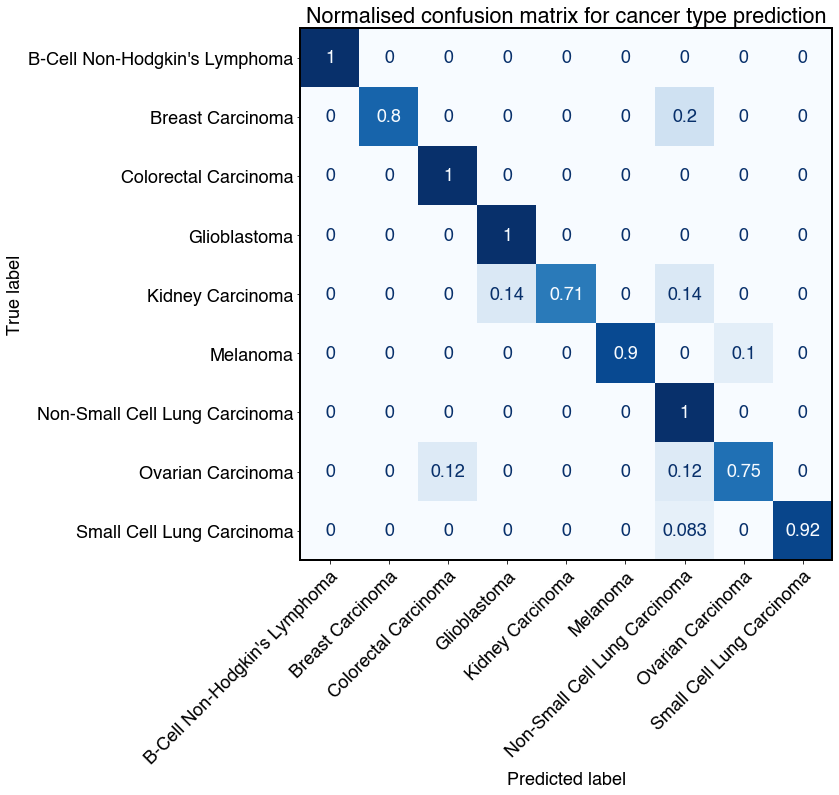

In [29]:
fig, ax = plt.subplots(1, figsize=(12, 12))
plot_confusion_matrix(clf,
                      X_test,
                      y_test,
                      cmap=plt.cm.Blues,
                      ax=ax,
                      normalize='true')
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.title("Normalised confusion matrix for cancer type prediction")
# remove the colorbar
ax.images[-1].colorbar.remove()
plt.tight_layout()
plt.savefig("../../plots/landscape/cancer_type_confusion.pdf", dpi=500)

In [9]:
y_pred = clf.predict(X_test)

In [10]:
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

B-Cell Non-Hodgkin's Lymphoma       1.00      1.00      1.00         8
             Breast Carcinoma       1.00      0.80      0.89        10
         Colorectal Carcinoma       0.91      1.00      0.95        10
                 Glioblastoma       0.89      1.00      0.94         8
             Kidney Carcinoma       1.00      0.71      0.83         7
                     Melanoma       1.00      0.90      0.95        10
Non-Small Cell Lung Carcinoma       0.77      1.00      0.87        17
            Ovarian Carcinoma       0.86      0.75      0.80         8
    Small Cell Lung Carcinoma       1.00      0.92      0.96        12

                     accuracy                           0.91        90
                    macro avg       0.94      0.90      0.91        90
                 weighted avg       0.92      0.91      0.91        90



In [30]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(data_sample.iloc[:,:-2])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [46]:
writer = pd.ExcelWriter('../../result_files/cancer_top_100_proteins.xlsx', engine='xlsxwriter')
cancers = sorted(set(y))
cancer_top50_all = []
for i in range(len(cancers)):
    index = np.argsort(-np.average(np.abs(shap_values[i]), axis=0))[:100]
    top_proteins = proteins[index]
    top_shap_values = np.average(np.abs(shap_values[i]), axis=0)[index]
    cancer_top50_all.extend(proteins[index[:50]])
    df = pd.DataFrame({'protein':top_proteins, 'importance':top_shap_values})
    df.to_excel(writer, sheet_name=cancers[i], index=False)
df = pd.DataFrame({'protein': list(set(cancer_top50_all))})
df.to_excel(writer, sheet_name='Top50_all', index=False)
writer.save()

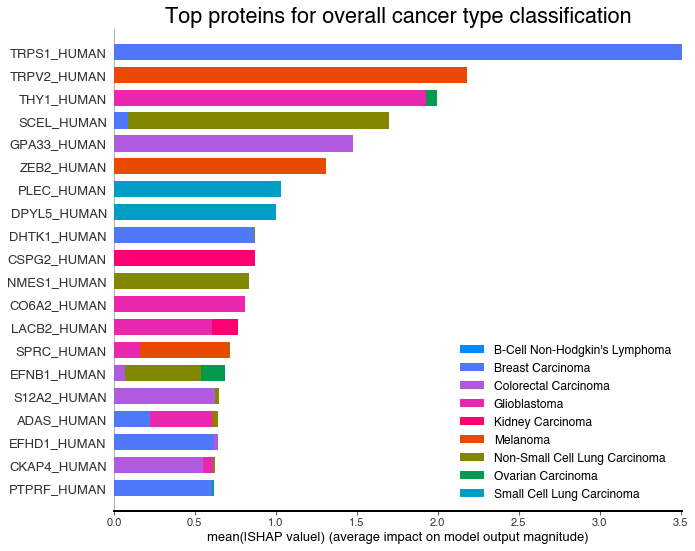

In [38]:
plt.figure(figsize=(10,8))
plt.title("Top proteins for overall cancer type classification")
shap.summary_plot(shap_values,
                  data_sample.iloc[:, :-2],
                  class_inds='original',
                  class_names=sorted(set(y)),
                  show=False,
                  plot_size=None)
plt.tight_layout()
plt.savefig("../../plots/landscape/cancer_type_overall_shap.pdf", dpi=500)

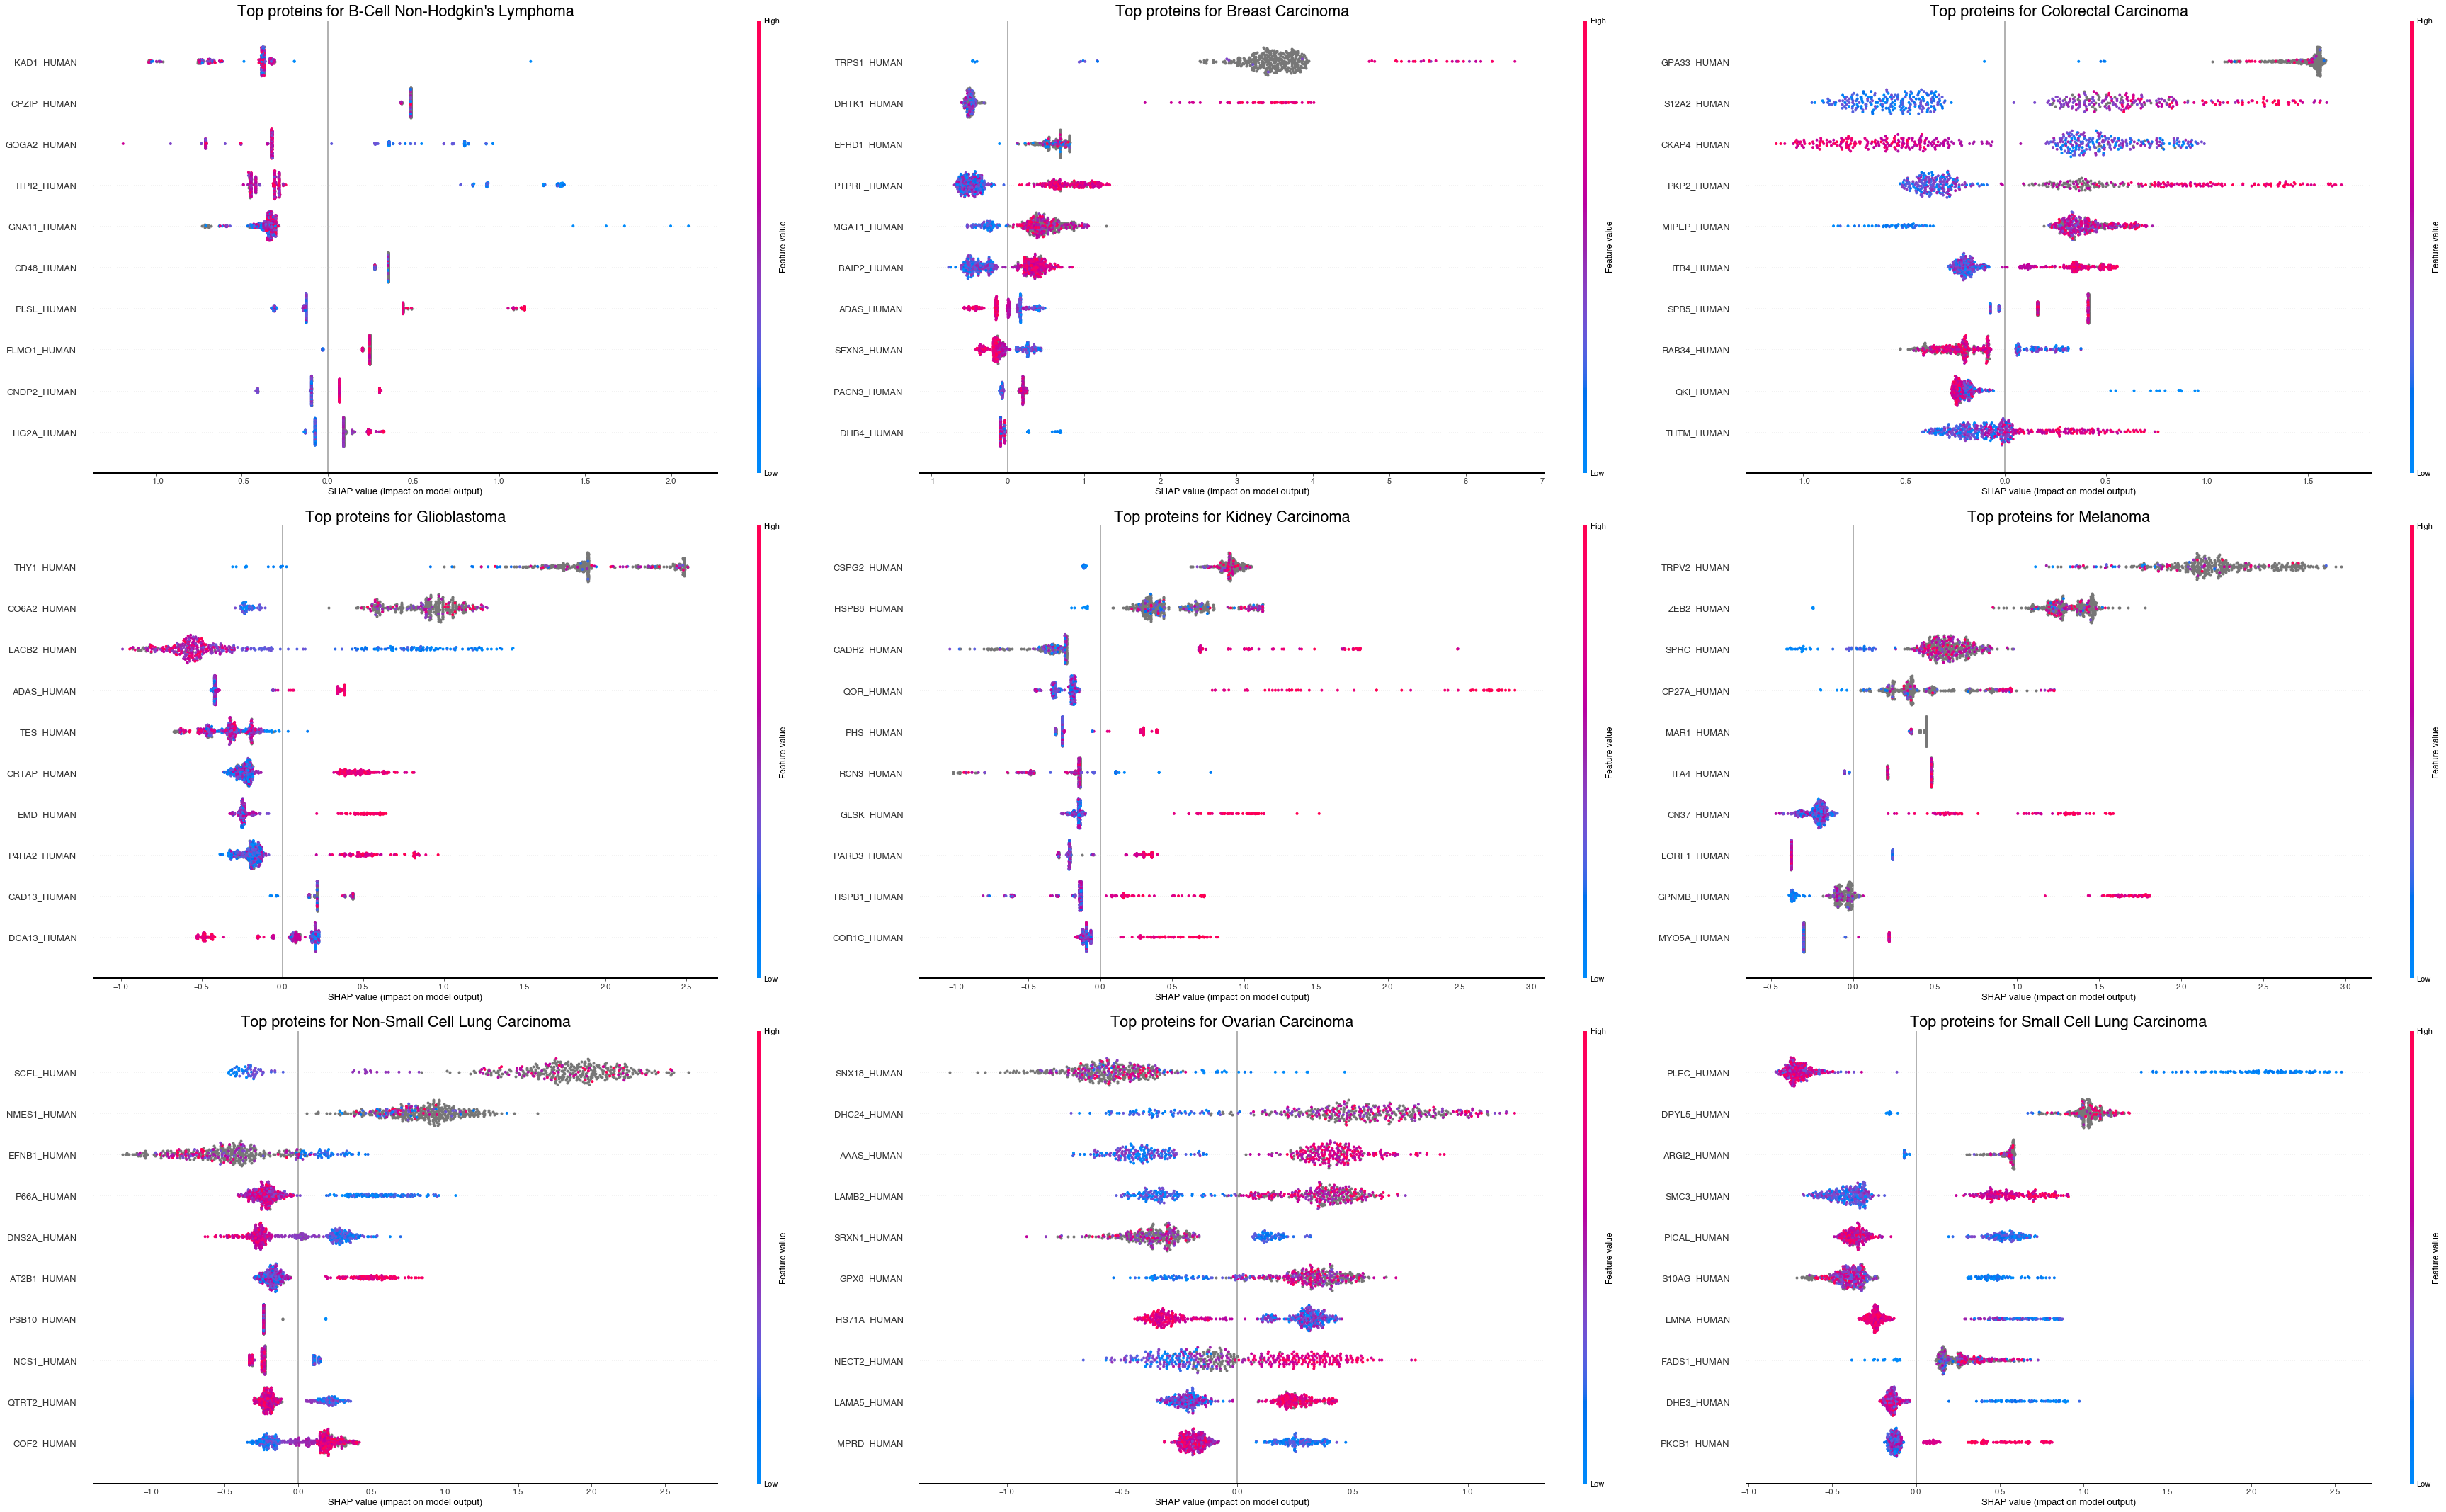

In [35]:
plt.figure(figsize=(50, 30))
for i in range(len(sorted(set(y)))):
    cancer_type = sorted(set(y))[i]
    plt.subplot(3, 3, i + 1)
    plt.title(f'Top proteins for {cancer_type}')
    shap.summary_plot(shap_values[i],
                      data_sample.iloc[:, :-2],
                      max_display=10,
                      show=False,
                      plot_size=None)
#     ax[i // 5, i % 5].figure = fig
plt.tight_layout()
plt.savefig("../../plots/landscape/cancer_type_shap.pdf", dpi=500)

In [29]:
[x for x in proteins if 'PSA' in x]

['PSA1_HUMAN',
 'PSA2_HUMAN',
 'PSA3_HUMAN',
 'PSA4_HUMAN',
 'PSA5_HUMAN',
 'PSA6_HUMAN',
 'PSA7_HUMAN',
 'PSA_HUMAN']